In [110]:
import pyedflib
import mylib
import mvar
import mygraph
import numpy as np
import pandas as pd
from igraph import Graph
import re
import igraph
import os
import importlib
importlib.reload(mylib)
from pylab import hist

In [111]:
case_open = "./data/S001R01.edf"
case_closed = "./data/S001R02.edf"

#### 1.1

Estimate functional brain connectivity among 64 channels using one of the MVAR estimators: 

- Partial Directed Coherence (PDC), 
- Direct Transfer Function (DTF). 

Select **one relevant frequency value**. 

Apply a **threshold** so that the resulting binary connectivity matrices have network density equal to 20%. 

Create a graphical representation of the binary adjacency matrix.

In [3]:
Gd = mylib.receive_data(path = case_open, freq = 10, threshold=0.1, DTF = True)

Loading data from ./data/S001R01.edf ...
...done
Computing DFT...
... done
Building network to analyse interactions at 10 Hz
Applying a threshold on network density of 5 % ...
... done


#### 1.2 

Perform task 1.1 using PDC estimator also 

In [30]:
Gp = mylib.receive_data(path = case_open, freq = 10, threshold=0.1, DTF = False)

Loading data from ./data/S001R01.edf ...
...done
Computing PDC
... done
Building network to analyse interactions at 10 Hz
Applying a threshold on network density of 10 % ...
... done


#### 1.3 

Perform task 1.1 using thresholds yielding the following density values: 1%, 5%, 10%, 20%, 30%, 50%.

In [5]:
densities = [0.05, 0.1, 0.2, 0.3, 0.5]
densities = densities[::-1]
graphs_over_densities = []
for density in densities:
    graphs_over_densities.append(mylib.receive_data(path = case_open, freq = 10, threshold=density, DTF = False))
graphs_over_densities

Loading data from ./data/S001R01.edf ...
...done
Computing PDC
... done
Building network to analyse interactions at 10 Hz
Applying a threshold on network density of 50 % ...
... done
Loading data from ./data/S001R01.edf ...
...done
Computing PDC
... done
Building network to analyse interactions at 10 Hz
Applying a threshold on network density of 30 % ...
... done
Loading data from ./data/S001R01.edf ...
...done
Computing PDC
... done
Building network to analyse interactions at 10 Hz
Applying a threshold on network density of 20 % ...
... done
Loading data from ./data/S001R01.edf ...
...done
Computing PDC
... done
Building network to analyse interactions at 10 Hz
Applying a threshold on network density of 10 % ...
... done
Loading data from ./data/S001R01.edf ...
...done
Computing PDC
... done
Building network to analyse interactions at 10 Hz
Applying a threshold on network density of 5 % ...
... done


#### 1.5

Make a topographical representation of the networks.

In [31]:
def testplot(G, name, visual_style):
    out = igraph.plot(G, bbox=(0, 0, 600, 400), **visual_style)
    out.save(name + '.png')
    return out

In [34]:
print("Making a topological representation")

visual_style = {}
visual_style["vertex_size"] = 25
visual_style["vertex_color"] = "white"
visual_style["vertex_label"] = Gd.vs["label"]
visual_style["edge_width"] = [weight for weight in Gd.es["weight"]]
visual_style["layout"] = Gd.vs["coordinates"]

G_open = Gp # this is already calcuated
G_closed = mylib.receive_data(path = case_closed, freq = 10, threshold=0.1, DTF = False)

Making a topological representation
Loading data from ./data/S001R02.edf ...
...done
Computing PDC
... done
Building network to analyse interactions at 10 Hz
Applying a threshold on network density of 10 % ...
... done


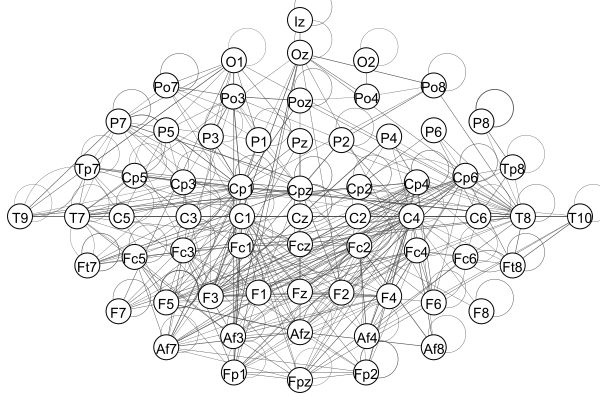

In [38]:
testplot(G = G_open, name = "open_top_repr", visual_style=visual_style)

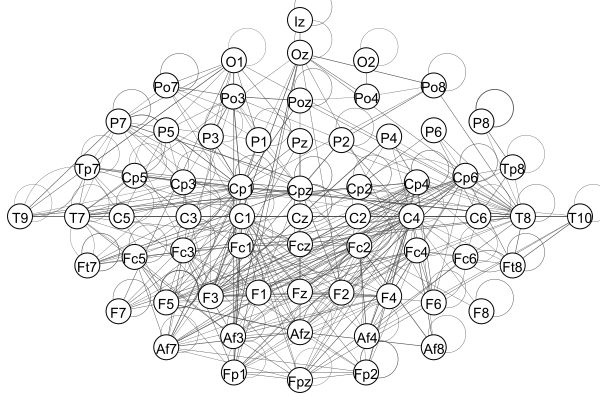

In [37]:
testplot(G = G_open, name = "closed_top_repr", visual_style=visual_style)

#### 1.6 

Perform task 1.1 considering a **second frequency value** belonging to a **different EEG rhythm** with respect to the first choice.

In [46]:
Gd = receive_data(case_open, freq = 28, threshold = 0.1, DTF = True)

Loading data from ./data/S001R01.edf ...
...done
Computing DFT...
... done
Building network to analyse interactions at 28 Hz
Applying a threshold on network density of 10 % ...
... done


#### 2.1

Compute 

- binary global (clustering coefficient, path length) graph indices
- local (degree,in/out-degree) graph indices. 

List the highest 10 channels for local indices

In [61]:
def graph_indices(G, weights = False):
    
    if weights:
        print("Macroscopic Network Analysis")
        # global clustering coefficient
        # https://igraph.org/python/doc/igraph.Graph-class.html#transitivity_avglocal_undirected
        print("global clustering coefficient = ", round(G.transitivity_avglocal_undirected(weights = "weight"), 3))

        # average path length
        # https://igraph.org/python/doc/igraph.GraphBase-class.html#average_path_length
        print("global average path lenght = ", round(G.average_path_length(directed = True), 3))
        print("\t the latter is calculated regardless from the weights")

        print("Microscopic Network Analysis")
        local_ind = pd.DataFrame.from_dict(      {
                "channel" : Gd.vs["label"] ,
                "strength" : Gd.strength(mode = 3,  weights = "weight"),
                "out-strength" : Gd.strength(mode = 1,  weights = "weight"),
                "in-strength" : Gd.strength(mode = 2,  weights = "weight")
                }
        )

        local_ind.set_index("channel", inplace = True)
        print("Top 10 channels by generalized degree\n", local_ind.sort_values(by = "strength", ascending = False)[1:10]["strength"])
        print("Top 10 channels by generalized OUT degree\n", local_ind.sort_values(by = "out-strength", ascending = False)[1:10]["out-strength"])
        print("Top 10 channels by generalized IN degree\n", local_ind.sort_values(by = "in-strength", ascending = False)[1:10]["in-strength"])
    
    else:
        print("Macroscopic Network Analysis")
        # global clustering coefficient
        # https://igraph.org/python/doc/igraph.Graph-class.html#transitivity_avglocal_undirected
        print("global clustering coefficient = ", round(G.transitivity_avglocal_undirected(), 3))

        # average path length
        # https://igraph.org/python/doc/igraph.GraphBase-class.html#average_path_length
        print("global average path lenght = ", round(G.average_path_length(directed = True), 3))

        print("Microscopic Network Analysis")
        local_ind = pd.DataFrame.from_dict(      {
                        "channel" : G.vs["label"] ,
                        "degree" : G.strength(mode = 3),
                        "out-degree" : G.strength(mode = 1),
                        "in-degree" : G.strength(mode = 2)
                        }
                )

        local_ind.set_index("channel", inplace = True)
        print("Top 10 channels by degree\n", local_ind.sort_values(by = "degree", ascending = False)[1:10]["degree"])
        print("Top 10 channels by OUT degree\n", local_ind.sort_values(by = "out-degree", ascending = False)[1:10]["out-degree"])
        print("Top 10 channels by IN degree\n", local_ind.sort_values(by = "in-degree", ascending = False)[1:10]["in-degree"])

In [62]:
graph_indices(G_open, weights=False)

Macroscopic Network Analysis
global clustering coefficient =  0.394
global average path lenght =  2.491
Microscopic Network Analysis
Top 10 channels by degree
 channel
C1     31.0
T8     28.0
Cp1    25.0
Cp4    24.0
F3     23.0
Fc2    22.0
Afz    21.0
T7     20.0
Cp6    19.0
Name: degree, dtype: float64
Top 10 channels by OUT degree
 channel
Fp1    17.0
T7     17.0
Af7    16.0
F5     15.0
Af3    14.0
F3     12.0
F1     11.0
Fz     11.0
P7     10.0
Name: out-degree, dtype: float64
Top 10 channels by IN degree
 channel
C1     29.0
Cp1    24.0
Cp4    23.0
Fc2    18.0
Cpz    15.0
Cp6    15.0
O1     15.0
Fc1    15.0
Fc4    13.0
Name: in-degree, dtype: float64


In [63]:
graph_indices(G_closed, weights=False)

Macroscopic Network Analysis
global clustering coefficient =  0.39
global average path lenght =  2.758
Microscopic Network Analysis
Top 10 channels by degree
 channel
T8     29.0
Cp6    25.0
C1     25.0
Cp1    24.0
F3     23.0
Fc4    22.0
Cp2    21.0
C3     21.0
F1     20.0
Name: degree, dtype: float64
Top 10 channels by OUT degree
 channel
F5     16.0
F1     15.0
Af3    14.0
T7     14.0
Fz     14.0
Af7    13.0
F2     13.0
F4     11.0
Fp2    11.0
Name: out-degree, dtype: float64
Top 10 channels by IN degree
 channel
C1     24.0
Cp1    23.0
Cp6    22.0
Fc4    20.0
C3     19.0
Cp2    19.0
Fc1    17.0
Cz     15.0
Cp3    14.0
Name: in-degree, dtype: float64


#### 2.2

Search in the literature a definition of **small-worldness index** and compute it.

In [56]:
#%% 2.2 # to be fixed !!
import bct

print("Calculating Small World Index...")

Actual = np.array(Gd.get_adjacency(attribute = "weight").data)
Lattice, a, b, iter2 = bct.latmio_dir(Actual, 10, D = None)
#Random, iter1 = bct.randmio_dir(Actual, 20)


# Bootstrap
B = 50
Lr = list()
Cr = list()
for i in range(B):
    Random, iter1 = bct.randmio_dir(Actual, 10)
    print(i)
    #print(Random[0,1])
    Lr.append(Graph.Weighted_Adjacency(Random.tolist(), mode = 0).average_path_length(directed = True))
    Cr.append(Graph.Weighted_Adjacency(Random.tolist(), mode = 0).transitivity_undirected())
    #print(i, Lr, Cr)
    
Lr_mean = sum(Lr)/float(len(Lr))
Cr_mean = sum(Cr)/float(len(Cr))


L = Graph.Weighted_Adjacency(Actual.tolist(), mode = 0).average_path_length(directed = True)
Ll = Graph.Weighted_Adjacency(Lattice.tolist(), mode = 0).average_path_length(directed = True)
#Lr = Graph.Weighted_Adjacency(Random.tolist(), mode = 0).average_path_length(directed = True)

C = Graph.Weighted_Adjacency(Actual.tolist(), mode = 0).transitivity_undirected()
Cl = Graph.Weighted_Adjacency(Lattice.tolist(), mode = 0).transitivity_undirected()
#Cr = Graph.Weighted_Adjacency(Random.tolist(), mode = 0).transitivity_undirected()

SWI = mylib.swi(L, Ll, Lr_mean, C, Cl, Cr_mean)
#[mylib.swi(L, Ll, Lr, C, Cl, Cr) for Lr, Cr in ]
print("SWI =", SWI)

Calculating Small World Index...
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
SWI = -0.26829694629350165


In [59]:
print((L-Ll)/(Lr_mean-Ll))

print((C-Cr_mean)/(Cl-Cr_mean))

-0.2697267277158043
0.9946991481548348


#### 2.4

Study the behaviour of global graph indices in function of network density (see point 2.3 for density values).

Studying the behaviour of global graph indices in function of network density...
Ploting the result of the analysis


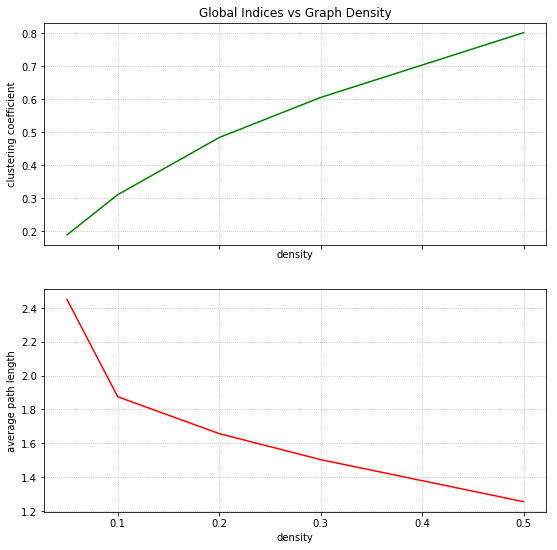

In [25]:
#%% 2.4 Study the behaviour of global graph indices in function of network density
print("Studying the behaviour of global graph indices in function of network density...")
densities = [0.05, 0.1, 0.2, 0.3, 0.5] # edit these with the ones provided by the prof

clustering_coeffs = []
average_path_lengths =  []
# there is a specific reason why we start from higher densities and then we
# decrease it: the function applyThreshold takes a graph and simply picks less 
# important edges (to which correspond low weights) erasing them from the network:
# to do that it has to find the minimum above N* x N* weights. 
# This is quite computationally expensive in our simple implementation:
# to speed up a bit our analysis we put the function in the condition of having
# at each step a smaller amount N*, avoiding to replicate the same minimizations
# multiple times
D, freqs = mvar.DTF(A_est, sigma, T)
freq = 10
D = D[np.where(freqs == mylib.find_nearest(freqs, freq)),:,:].reshape(64, 64)
Gd = Graph.Weighted_Adjacency(D.tolist(), mode = 0)
for density in densities[::-1]:
    Gd = mygraph.applyTreshold(Gd, density)
    clustering_coeffs.append(Gd.transitivity_undirected())
    average_path_lengths.append(Gd.average_path_length(directed = False, unconn=True))
print("Ploting the result of the analysis")
mylib.plot_analysis(densities, clustering_coeffs, average_path_lengths)

#### 2.5 

Make a Topographical representation of local indices

Topographical representation of weighted degree


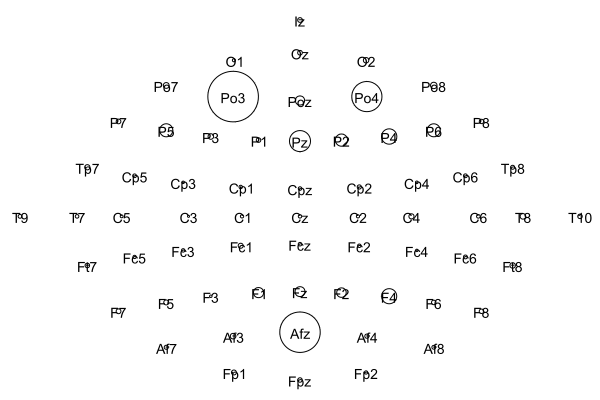

In [7]:
#%% 2.5 Make a Topographical representation of local indices
import matplotlib.pyplot as plt
Gd.vs["strength"] = Gd.strength(mode = 3, weights = "weight")
Gd.vs["in-strenght"] = Gd.strength(mode = 2, weights = "weight")
Gd.vs["out-strength"] = Gd.strength(mode = 1, weights = "weight")

visual_style["vertex_size"] = [3* strength for strength in Gd.vs["strength"]]
visual_style["edge_width"] = 0

print("Topographical representation of weighted degree")
testplot(G = G_open, name = "open_degree", visual_style=visual_style)
testplot(G = G_closed, name = "closed_degree", visual_style=visual_style)

Topographical representation of weighted in-degree


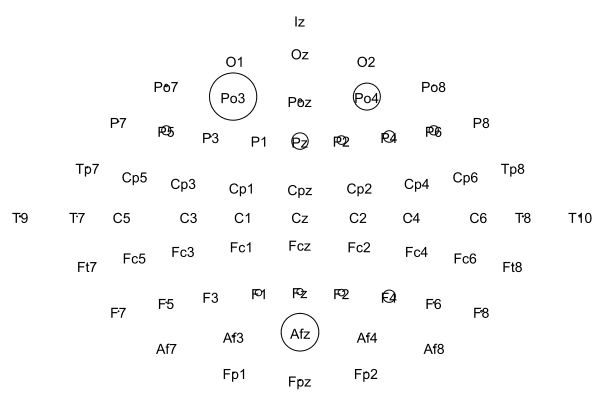

In [8]:
visual_style["vertex_size"] = [3* strength for strength in Gd.vs["in-strenght"]]
visual_style["edge_width"] = 0
print("Topographical representation of weighted in-degree")
testplot(G = G_open, name = "open_inDegree", visual_style=visual_style)
testplot(G = G_closed, name = "closed_inDegree", visual_style=visual_style)

Topographical representation of weighted out-degree


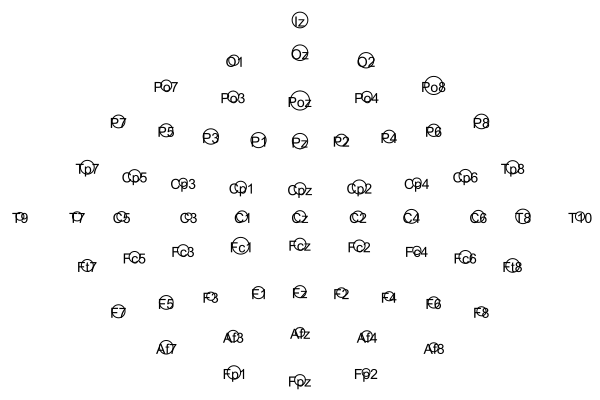

In [9]:
visual_style["vertex_size"] = [10* strength for strength in Gd.vs["out-strength"]]
visual_style["edge_width"] = 0

print("Topographical representation of weighted out-degree")
testplot(G = G_open, name = "open_outDegree", visual_style=visual_style)
testplot(G = G_closed, name = "closed_outDegree", visual_style=visual_style)

#### 2.7

Perform point 2.1 considering the **weighted** version of the **graph indices**

In [64]:
graph_indices(G_open, weights=True)

Macroscopic Network Analysis
global clustering coefficient =  0.822
global average path lenght =  2.491
	 the latter is calculated regardless from the weights
Microscopic Network Analysis
Top 10 channels by generalized degree
 channel
Afz    13.473430
Po4    10.041832
Pz      7.020175
P4      5.114191
F4      5.039221
P5      4.351623
P6      4.329907
P2      4.069092
F1      3.367227
Name: strength, dtype: float64
Top 10 channels by generalized OUT degree
 channel
Po8    1.813204
Fc1    1.675881
Iz     1.572640
Oz     1.563477
O2     1.540559
P3     1.538286
Pz     1.534867
P1     1.512976
P8     1.460260
Name: out-strength, dtype: float64
Top 10 channels by generalized IN degree
 channel
Afz    12.541498
Po4     9.003333
Pz      5.485308
F4      4.119901
P4      3.849173
P6      3.095992
P5      3.044212
P2      2.886456
F2      2.196047
Name: in-strength, dtype: float64


In [65]:
graph_indices(G_closed, weights=True)

Macroscopic Network Analysis
global clustering coefficient =  0.776
global average path lenght =  2.758
	 the latter is calculated regardless from the weights
Microscopic Network Analysis
Top 10 channels by generalized degree
 channel
Afz    13.473430
Po4    10.041832
Pz      7.020175
P4      5.114191
F4      5.039221
P5      4.351623
P6      4.329907
P2      4.069092
F1      3.367227
Name: strength, dtype: float64
Top 10 channels by generalized OUT degree
 channel
Po8    1.813204
Fc1    1.675881
Iz     1.572640
Oz     1.563477
O2     1.540559
P3     1.538286
Pz     1.534867
P1     1.512976
P8     1.460260
Name: out-strength, dtype: float64
Top 10 channels by generalized IN degree
 channel
Afz    12.541498
Po4     9.003333
Pz      5.485308
F4      4.119901
P4      3.849173
P6      3.095992
P5      3.044212
P2      2.886456
F2      2.196047
Name: in-strength, dtype: float64


(array([ 5.,  8., 10., 16.,  9.,  6.,  5.,  2.,  2.,  1.]),
 array([0.78442607, 1.51770886, 2.25099165, 2.98427444, 3.71755723,
        4.45084002, 5.18412281, 5.9174056 , 6.65068839, 7.38397118,
        8.11725397]),
 <a list of 10 Patch objects>)

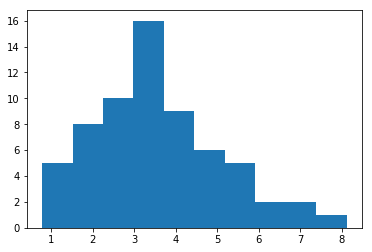

In [66]:
hist_open = hist(G_open.strength(mode = 3,  weights = "weight"), )
hist_open

(array([ 6.,  6., 15., 15.,  9., 10.,  1.,  1.,  0.,  1.]),
 array([0.41195636, 1.29734115, 2.18272594, 3.06811073, 3.95349552,
        4.83888031, 5.7242651 , 6.60964989, 7.49503468, 8.38041947,
        9.26580426]),
 <a list of 10 Patch objects>)

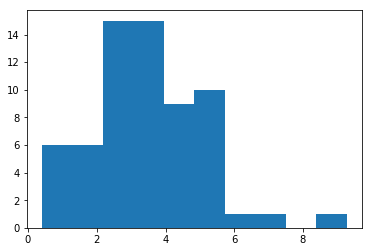

In [67]:
hist_open = hist(G_closed.strength(mode = 3,  weights = "weight"))
hist_open

In [147]:
#%% 3 Motif analysis

G_open = mylib.receive_data(path = case_open, freq = 10, threshold=0.05, DTF = True)
G_closed = mylib.receive_data(path = case_closed, freq = 10, threshold=0.05, DTF = True)

Loading data from ./data/S001R01.edf ...
...done
Computing DFT...
... done
Building network to analyse interactions at 10 Hz
Applying a threshold on network density of 5 % ...
... done
Loading data from ./data/S001R02.edf ...
...done
Computing DFT...
... done
Building network to analyse interactions at 10 Hz
Applying a threshold on network density of 5 % ...
... done


In [113]:
path = './data/motifAnalysis_OPEN.txt'
print("Writing input file for Motif Analysis to", path, "...")
os.remove(path)
mylib.write_inputFileForMotifAnalysis(G_open, file = path)
print("\n.. done")

path = './data/motifAnalysis_CLOSED.txt'
print("Writing input file for Motif Analysis to", path, "...")
os.remove(path)
mylib.write_inputFileForMotifAnalysis(G_closed, file = path)
print("\n.. done")

Loading data from ./data/S001R01.edf ...
...done
Computing DFT...
... done
Building network to analyse interactions at 10 Hz
Applying a threshold on network density of 5 % ...
... done
Loading data from ./data/S001R02.edf ...
...done
Computing DFT...
... done
Building network to analyse interactions at 10 Hz
Applying a threshold on network density of 5 % ...
... done
Writing input file for Motif Analysis to ./data/motifAnalysis_OPEN.txt ...

.. done
Writing input file for Motif Analysis to ./data/motifAnalysis_CLOSED.txt ...

.. done


In [145]:
def count_app_in_motif(G, path, name):
    """
    
    """    
    motifs = pd.read_csv(path, sep = "\t" , skiprows = 5, header = None)
    G.es["appear_in_mot"] = [0 for i in G.es]
    for motif in range(motifs.shape[0]): # connections.shape[0]
        A = int(motifs.iloc[[motif]][0])
        B = int(motifs.iloc[[motif]][1])
        C = int(motifs.iloc[[motif]][2])
        
        G.es[G.get_eid(B, C)]["appear_in_mot"] += 1
        G.es[G.get_eid(A, C)]["appear_in_mot"] += 1
        
    visual_style = {}
    Gd.es["arrow_size"] = [0.1 for edge in Gd.es]
    visual_style["vertex_size"] = 30
    visual_style["vertex_color"] = "white"
    visual_style["vertex_label"] = G.vs["label"]
    visual_style["edge_width"] = [0.1 * app for app in G.es["appear_in_mot"]]
    visual_style["layout"] = G.vs["coordinates"]

    return(testplot(G = G, name = name, visual_style=visual_style))

In [146]:
count_app_in_motif(G_open, "./data/motifAnalysis_OPEN_MEMBERS.txt", "motif_open")

InternalError: Error at src\type_indexededgelist.c:1166: Cannot get edge id, no such edge, Invalid value

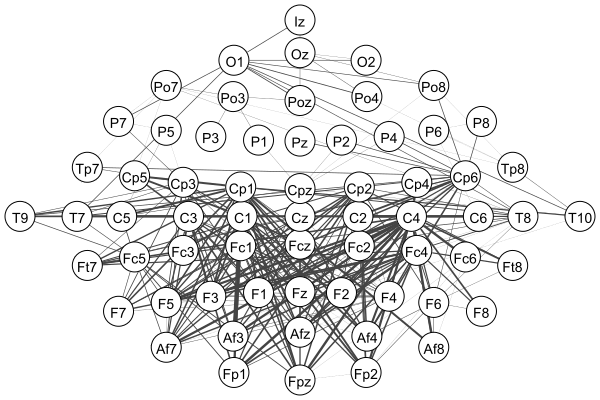

In [109]:
count_app_in_motif(G_closed, "./data/motifAnalysis_CLOSED_MEMBERS.txt", "motif_closed")

In [134]:
#%% 4.1 Community detection

def louvain(G):
    import louvain
    louvain.set_rng_seed(123452)
    G.vs['degree'] = G.degree()
    #G = np.matrix(G.get_adjacency(attribute='weight').data)
    #G = pos_Igraph(G,do_plot=False)
    partition = louvain.find_partition(G, louvain.ModularityVertexPartition,weights=G.es['weight'])
    
    return(partition, G)

In [135]:
part_open,G_open = louvain(G_open)
print("The estimated number of communities for eyes-open case is",len(set(part_open.membership)))
print('\n')
print("Communities")
for n in range(0,len(part_open)):
    print('Community number', n, '- size:', len(part_open[n]))
    
#Create a dictionary whith keys as channels (names of our nodes) and values the community they belong
print("Case: eyes-open")
comm_detect = dict(zip(G_open.vs['label'], part_open.membership))
print("A dictionary whith keys as channels (names of our nodes) and values the community they belong:")
print('\n')
new_dict = {}
for pair in comm_detect.items():
    if pair[1] not in new_dict.keys():
        new_dict[pair[1]] = []

    new_dict[pair[1]].append(pair[0])

print(dict(sorted(new_dict.items())))

The estimated number of communities for eyes-open case is 4


Communities
Community number 0 - size: 31
Community number 1 - size: 21
Community number 2 - size: 11
Community number 3 - size: 1
Case: eyes-open
A dictionary whith keys as channels (names of our nodes) and values the community they belong:


{0: ['Fc5', 'Fc3', 'Fc1', 'Fcz', 'Fc2', 'Fc4', 'C5', 'C3', 'C1', 'Cz', 'C2', 'Cpz', 'Fp1', 'Fpz', 'Fp2', 'Af7', 'Af3', 'Afz', 'Af4', 'Af8', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'Ft7', 'T7', 'Pz'], 1: ['Cp5', 'Cp3', 'Cp1', 'Cp2', 'T9', 'Tp7', 'P7', 'P5', 'P3', 'P1', 'P2', 'P8', 'Po7', 'Po3', 'Poz', 'Po4', 'Po8', 'O1', 'Oz', 'O2', 'Iz'], 2: ['Fc6', 'C4', 'C6', 'Cp4', 'Cp6', 'Ft8', 'T8', 'T10', 'Tp8', 'P4', 'P6'], 3: ['F8']}


In [136]:
part_closed,G_closed = louvain(G_closed)
print("The estimated number of communities for eyes-closed case is",len(set(part_closed.membership)))
print('\n')
print("Communities")
for n in range(0,len(part_closed)):
    print('Community number', n, '- size:', len(part_closed[n]))

    #Create a dictionary whith keys as channels (names of our nodes) and values the community they belong
print("Case: eyes-closed")
comm_detect = dict(zip(G_closed.vs['label'], part_closed.membership))
print("A dictionary whith keys as channels (names of our nodes) and values the community they belong:")
print('\n')
new_dict = {}
for pair in comm_detect.items():
    if pair[1] not in new_dict.keys():
        new_dict[pair[1]] = []

    new_dict[pair[1]].append(pair[0])

print(dict(sorted(new_dict.items())))

The estimated number of communities for eyes-closed case is 4


Communities
Community number 0 - size: 26
Community number 1 - size: 22
Community number 2 - size: 14
Community number 3 - size: 2
Case: eyes-closed
A dictionary whith keys as channels (names of our nodes) and values the community they belong:


{0: ['Fc5', 'Fc3', 'Fc1', 'Fcz', 'Fc2', 'Fc4', 'Fp1', 'Fpz', 'Fp2', 'Af7', 'Afz', 'Af4', 'Af8', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'Ft7', 'Pz', 'Po8', 'Oz'], 1: ['Fc6', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'Cp5', 'Cp3', 'Cp1', 'Cpz', 'Cp2', 'Cp4', 'Cp6', 'Ft8', 'T8', 'Tp8', 'P4', 'P6', 'Po7', 'Po3'], 2: ['T7', 'T9', 'Tp7', 'P7', 'P5', 'P3', 'P1', 'P2', 'P8', 'Poz', 'Po4', 'O1', 'O2', 'Iz'], 3: ['Af3', 'T10']}


At rest in eyes-open conditions


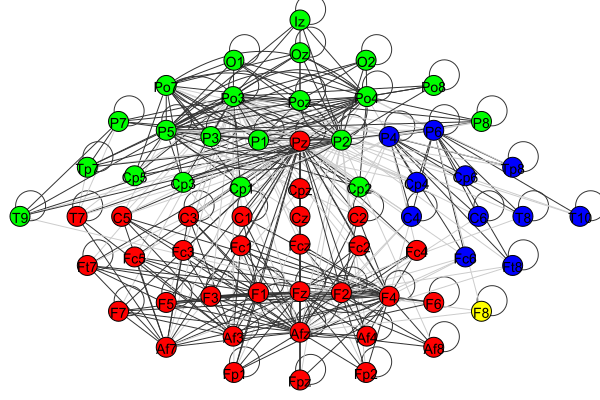

In [138]:
#%% 4.2 Graphical Representation of the Community Structure 
print("At rest in eyes-open conditions")
testplot(part_open, "liouvain_open", visual_style={"layout" : G_open.vs["coordinates"]})

At rest in eyes-closed conditions


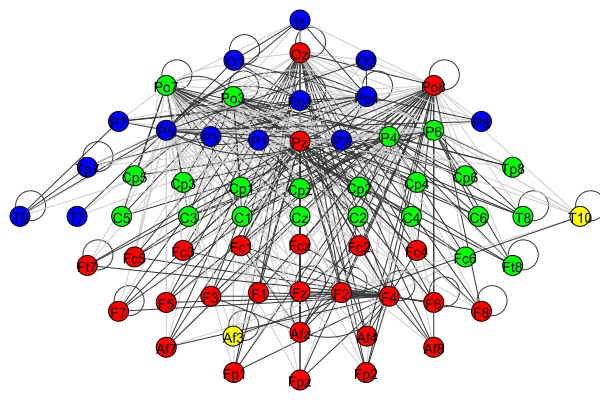

In [139]:
print("At rest in eyes-closed conditions")
testplot(part_closed, "liouvain_closed", visual_style={"layout" : G_open.vs["coordinates"]})

In [140]:
#%% 4.3 Modularity-based vs Information Theory-based approaches

The estimated number of communities for eyes-open case is 2
The estimated number of communities for eyes-closed case is 1
Graphs representations for both cases


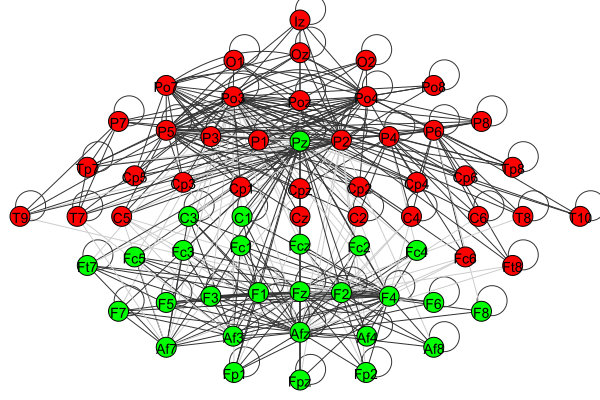

In [144]:
##Case OPEN

weights = G_open.es['weight']
comms_open = G_open.community_infomap(edge_weights = weights,trials = 50)
membership = comms_open.membership
print("The estimated number of communities for eyes-open case is",len(comms_open))

##Case CLOSED

weights = G_closed.es['weight']
comms_closed = G_closed.community_infomap(edge_weights = weights,trials = 50)
membership = comms_closed.membership
print("The estimated number of communities for eyes-closed case is",len(comms_closed))

print("Graphs representations for both cases")
testplot(comms_open, "infoTheo_open", visual_style={"layout" : G_open.vs["coordinates"]})


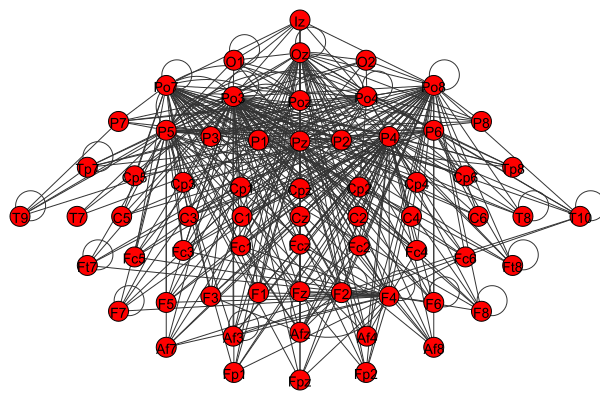

In [143]:
testplot(comms_closed, "infoTheo_closed", visual_style={"layout" : G_open.vs["coordinates"]})

Infomap always finds a single community containing all nodes of the network. However, a modularity-based methods, such as the Louvain method,finds a few communities (always more than one for both rest cases) for the specific average degree of our network. 

These results show that given the specified density of our network that we used the louvain algorithm (modularity based approach) tends to find a few small communities while the infomap method (information theory approach) it detects a single community in the same network with these specific dense connections.